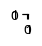

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

# Setting kwargs
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)
prime.rename(columns={'Mutant':'Peptide', 'Immunogenicity':'agg_label'},inplace=True)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}
# # train on good ol' Cedar 10-fold dataset
# train_dataset = cedar
# enc_weight_results = {}
# # Good ol' RandomForest
# model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
# trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_shannon,
#                                                             encoding_kwargs=encoding_kwargs, n_jobs=1)

# Check HLA pos-neg ratios & rebalance

## checks

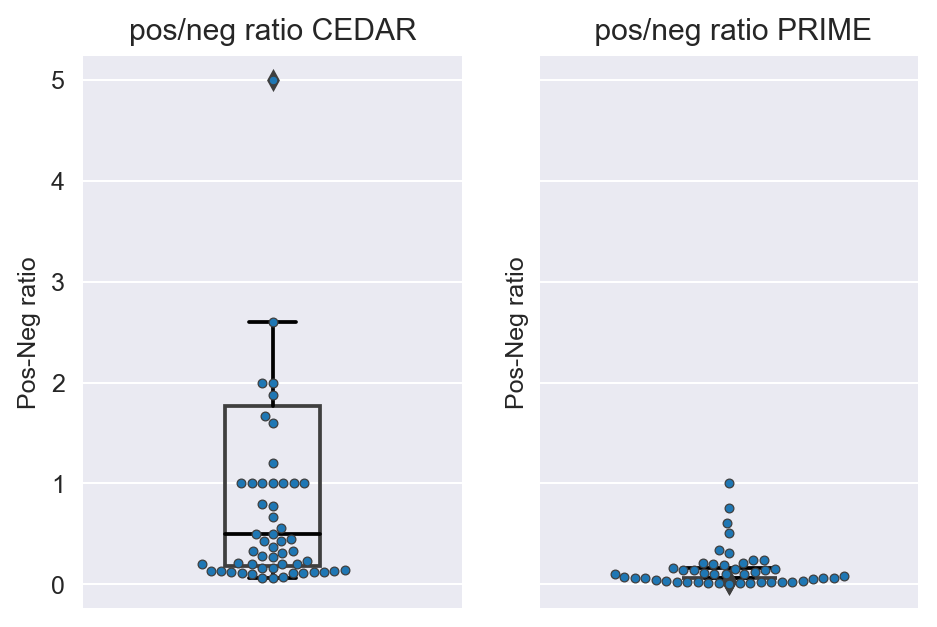

In [2]:
# POS-NEG ratio boxplot
f,a = plt.subplots(1,2, figsize=(6,4), sharey=True)
pd.options.display.max_rows=999
gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
# sorted_ratios.plot(kind='box', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
# sorted_ratios.plot(kind='swarm', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)

sns.boxplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[0], saturation=1,
           width=0.25, boxprops={'facecolor':'none'})
plt.setp(a[0].artists, edgecolor = 'k', facecolor='w')
plt.setp(a[0].lines, color='k')
sns.swarmplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[0], size=3.5, linewidth=0.5 )
a[0].set_title('pos/neg ratio CEDAR')
a[0].set_xlabel('')
# PRIME

gb_count = prime.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = prime.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
# sorted_ratios.plot(kind='box', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
# sorted_ratios.plot(kind='swarm', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)

sns.boxplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[1], saturation=1,
           width=0.25, boxprops={'facecolor':'none'})
plt.setp(a[1].artists, edgecolor = 'k', facecolor='w')
plt.setp(a[1].lines, color='k')
sns.swarmplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[1], size=3.5, linewidth=0.5 )
a[1].set_title(' pos/neg ratio PRIME')
a[1].set_xlabel('')
pd.options.display.max_rows=10 

Text(0.5, 1.0, 'Pos-Neg ratio vs n_pos per HLA for CEDAR')

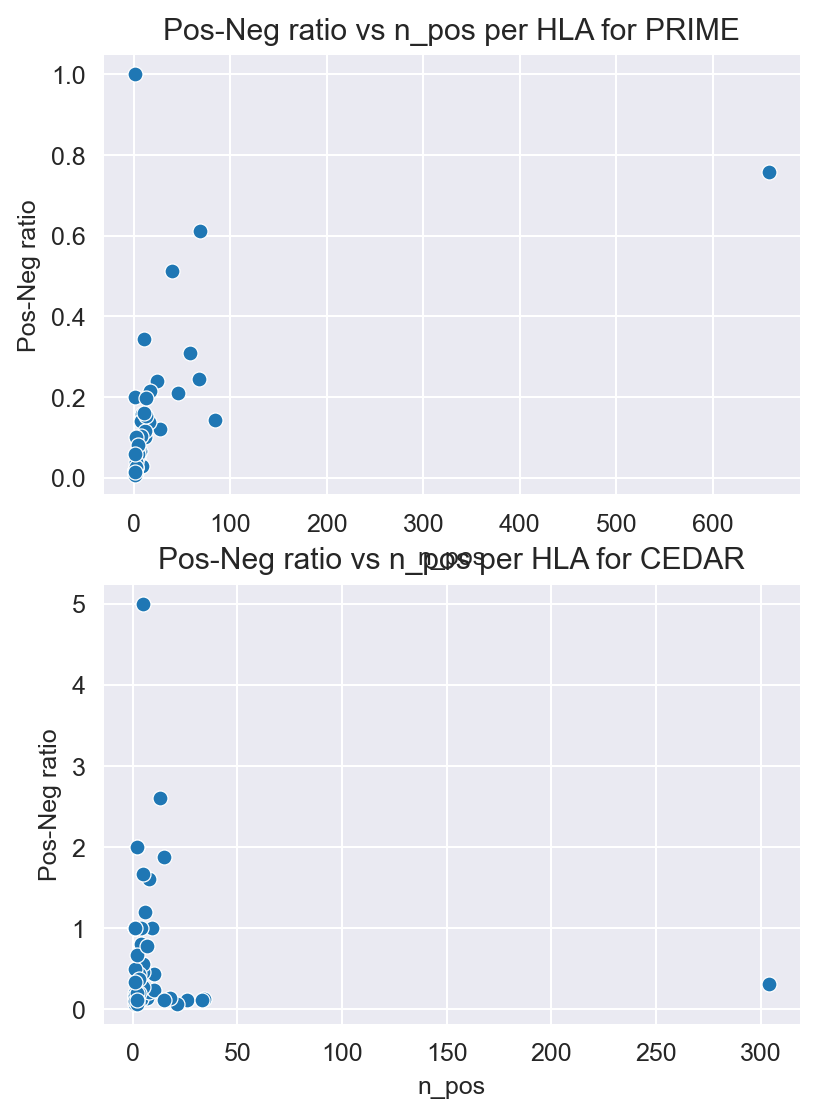

In [3]:
f,a = plt.subplots(2,1, figsize=(5,7))


gb_count = prime.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = prime.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios, left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= 'Pos-Neg ratio', linewidth=0.5, ax = a[0])

a[0].set_title('Pos-Neg ratio vs n_pos per HLA for PRIME')


gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)

npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios, left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= 'Pos-Neg ratio', linewidth=0.5, ax = a[1])

a[1].set_title('Pos-Neg ratio vs n_pos per HLA for CEDAR')


## rebalance

In [40]:
ref = round(sorted_ratios.loc['HLA-A02:01'].item(), 3)
print(ref)
hla_to_balance = sorted_ratios.query('`Pos-Neg ratio`>1 and HLA != "HLA-A02:01"').index
hla_to_balance

0.307


Index(['HLA-A69:01', 'HLA-B44:08', 'HLA-B37:04', 'HLA-C08:02', 'HLA-A02:05',
       'HLA-B39:06', 'HLA-C07:01', 'HLA-A02:11', 'HLA-A02:24', 'HLA-A30:02',
       'HLA-A03:02', 'HLA-C15:02', 'HLA-C07:02', 'HLA-C04:01', 'HLA-B37:01',
       'HLA-B40:01', 'HLA-C03:04', 'HLA-B44:02', 'HLA-A29:02', 'HLA-B13:02',
       'HLA-B54:01', 'HLA-B49:01', 'HLA-C06:02', 'HLA-C14:02', 'HLA-B35:03',
       'HLA-A31:01', 'HLA-A02:03', 'HLA-C03:03', 'HLA-C01:02', 'HLA-B40:02',
       'HLA-A11:02', 'HLA-B52:01', 'HLA-A25:01', 'HLA-A02:06', 'HLA-B51:01',
       'HLA-C05:01', 'HLA-A26:01', 'HLA-C12:02'],
      dtype='object', name='HLA')

In [41]:
import math
def get_closest_n(n_pos):
    d = {int(n_pos/ref): abs(ref-n_pos/int(n_pos/ref)),
         1+int(n_pos/ref): abs(ref-n_pos/(1+int(n_pos/ref))),
         int(n_pos/ref)-1 : abs(ref-n_pos/(int(n_pos/ref)-1))}
    return min(d, key=d.get)

get_closest_n(4)

13

In [56]:
for hla in hla_to_balance: 
    tmp=cedar.query('HLA==@hla')
    pos = tmp.query('agg_label==1')
    display(pos.groupby('len').agg(count=('Peptide','count')))
    print(hla)

,count
len,
9,1


HLA-A69:01


,count
len,
9,1


HLA-B44:08


,count
len,
9,1


HLA-B37:04


,count
len,
9,1
10,1


HLA-C08:02


,count
len,
9,1
11,1


HLA-A02:05


,count
len,
9,1


HLA-B39:06


,count
len,
9,2
11,1


HLA-C07:01


,count
len,
9,2
10,2


HLA-A02:11


,count
len,
11,1


HLA-A02:24


,count
len,
8,1
9,3
10,1


HLA-A30:02


,count
len,
11,1


HLA-A03:02


,count
len,
9,4
10,1


HLA-C15:02


,count
len,
9,5
10,5
11,3


HLA-C07:02


,count
len,
9,1
10,1


HLA-C04:01


,count
len,
9,2


HLA-B37:01


,count
len,
8,1
9,7
10,5
11,2


HLA-B40:01


,count
len,
9,3
10,2


HLA-C03:04


,count
len,
9,2
10,3
11,3


HLA-B44:02


,count
len,
9,5
10,1


HLA-A29:02


,count
len,
9,1


HLA-B13:02


,count
len,
10,1


HLA-B54:01


,count
len,
9,1


HLA-B49:01


,count
len,
9,2
10,2


HLA-C06:02


,count
len,
9,1


HLA-C14:02


,count
len,
9,1


HLA-B35:03


,count
len,
9,4
10,2
11,3


HLA-A31:01


,count
len,
9,1
10,3


HLA-A02:03


,count
len,
9,6
10,1


HLA-C03:03


,count
len,
9,2


HLA-C01:02


,count
len,
9,5


HLA-B40:02


,count
len,
9,1
10,1
11,1


HLA-A11:02


,count
len,
11,1


HLA-B52:01


,count
len,
8,1
9,3
11,1


HLA-A25:01


,count
len,
8,3
9,5
10,2


HLA-A02:06


,count
len,
8,1
9,2


HLA-B51:01


,count
len,
8,1
9,1
10,1


HLA-C05:01


,count
len,
10,2


HLA-A26:01


,count
len,
8,1


HLA-C12:02


In [61]:
cedar.query("HLA=='HLA-C07:02' and agg_label==1")

dict_keys([9, 10, 11])

In [27]:
display(cedar.query('HLA=="HLA-C15:02"')[['Peptide', 'HLA', 'trueHLA_EL_rank', 'len', 'agg_label']])
get_closest_n(5)

,Peptide,HLA,trueHLA_EL_rank,len,agg_label
886,GSILAYLVV,HLA-C15:02,1.3971,9,1
1189,ISLNNAVIEL,HLA-C15:02,1.8802,10,1
1471,KSSPFTAAA,HLA-C15:02,0.8938,9,0
1818,LTSTVQLIM,HLA-C15:02,0.3035,9,1
1836,LVRRTLLHV,HLA-C15:02,1.3372,9,1
2789,STVQLIMQL,HLA-C15:02,0.0413,9,1


16

In [30]:
def sample(

3

In [78]:
sorted(hla_to_balance)

['HLA-A02:03',
 'HLA-A02:05',
 'HLA-A02:06',
 'HLA-A02:11',
 'HLA-A02:24',
 'HLA-A03:02',
 'HLA-A11:02',
 'HLA-A25:01',
 'HLA-A26:01',
 'HLA-A29:02',
 'HLA-A30:02',
 'HLA-A31:01',
 'HLA-A69:01',
 'HLA-B13:02',
 'HLA-B35:03',
 'HLA-B37:01',
 'HLA-B37:04',
 'HLA-B39:06',
 'HLA-B40:01',
 'HLA-B40:02',
 'HLA-B44:02',
 'HLA-B44:08',
 'HLA-B49:01',
 'HLA-B51:01',
 'HLA-B52:01',
 'HLA-B54:01',
 'HLA-C01:02',
 'HLA-C03:03',
 'HLA-C03:04',
 'HLA-C04:01',
 'HLA-C05:01',
 'HLA-C06:02',
 'HLA-C07:01',
 'HLA-C07:02',
 'HLA-C08:02',
 'HLA-C12:02',
 'HLA-C14:02',
 'HLA-C15:02']

In [62]:
os.listdir('../output_xls/filtered_rank20/')[:5]

['HLA-A0203_10mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0202_11mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0201_12mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0210_11mers_humanproteome_chunk_3.xls_rank20.txt',
 'HLA-A0211_10mers_humanproteome_chunk_3.xls_rank20.txt']

In [73]:
datadir = '../output_xls/filtered_rank20/'
hla = 'HLA-A02:01'
fns = [x for x in os.listdir(datadir) if hla.replace(':','') in x]
fns

['HLA-A0201_12mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0201_11mers_humanproteome_chunk_0.xls_rank20.txt',
 'HLA-A0201_8mers_humanproteome_chunk_3.xls_rank20.txt',
 'HLA-A0201_8mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0201_11mers_humanproteome_chunk_1.xls_rank20.txt',
 'HLA-A0201_12mers_humanproteome_chunk_3.xls_rank20.txt',
 'HLA-A0201_12mers_humanproteome_chunk_1.xls_rank20.txt',
 'HLA-A0201_8mers_humanproteome_chunk_0.xls_rank20.txt',
 'HLA-A0201_11mers_humanproteome_chunk_3.xls_rank20.txt',
 'HLA-A0201_11mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0201_8mers_humanproteome_chunk_1.xls_rank20.txt',
 'HLA-A0201_12mers_humanproteome_chunk_0.xls_rank20.txt',
 'HLA-A0201_9mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0201_10mers_humanproteome_chunk_1.xls_rank20.txt',
 'HLA-A0201_10mers_humanproteome_chunk_0.xls_rank20.txt',
 'HLA-A0201_9mers_humanproteome_chunk_3.xls_rank20.txt',
 'HLA-A0201_10mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0201_9mers_hu

In [91]:
lens_to_read

dict_keys([9, 11])

In [94]:
# xs = ['abc-123', 'def-456', 'ghi-789', 'abc-456']

# if any("abc" in s for s in xs):
    


['HLA-A0205_9mers_humanproteome_chunk_1.xls_rank20.txt',
 'HLA-A0205_9mers_humanproteome_chunk_0.xls_rank20.txt',
 'HLA-A0205_9mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0205_9mers_humanproteome_chunk_3.xls_rank20.txt',
 'HLA-A0205_11mers_humanproteome_chunk_1.xls_rank20.txt',
 'HLA-A0205_11mers_humanproteome_chunk_0.xls_rank20.txt',
 'HLA-A0205_11mers_humanproteome_chunk_2.xls_rank20.txt',
 'HLA-A0205_11mers_humanproteome_chunk_3.xls_rank20.txt']

In [135]:
datadir = '../output_xls/filtered_rank20/'
samples_all = []
for hla in tqdm(hla_to_balance, leave=False): 
    tmp=cedar.query('HLA==@hla')
    pos = tmp.query('agg_label==1')
    neg = tmp.query('agg_label==0')
    lens_to_read = pos.groupby('len').agg(count=('Peptide','count')).to_dict()['count'].keys()
    fns = [x for x in os.listdir(datadir) if hla.replace(':','') in x]
    if len(fns)==0:
        continue
    df = pd.concat([pd.read_csv(f'{datadir}{s}', sep='\t', skiprows=1) for s in fns for k in lens_to_read if f'{k}mer' in s])
    df['len'] = df['Peptide'].apply(len)
    sample_hla = []
    if len(neg)==0:
        n_neg = get_closest_n(len(pos))
    else:
        n_neg = get_closest_n(len(pos))-len(neg)
        print('here', n_neg)
    # Get number to sample per positive, then complete the missing samples
    n_per = math.floor(n_neg/len(pos))
    for _, row in pos.iterrows():
        rank = row['trueHLA_EL_rank']
        len_ = len(row['Peptide'])
        lower, upper = rank-(.05*rank), rank+(.05*rank)
        sample_hla.append(df.query('EL_Rank >= @lower and EL_Rank<=@upper and len == @len_').sample(n_per))
    sample_hla = pd.concat(sample_hla)
    n_remaining = n_neg-len(sample_hla)
    if n_remaining<=0:
        continue
    else:
        rank = pos.trueHLA_EL_rank.mean()
        lower, upper = rank-(.05*rank), rank+(.05*rank)
        sample_hla = sample_hla.append(df.query('EL_Rank >= @lower and EL_Rank<=@upper and len==9').sample(n_remaining))
    
    sample_hla['HLA']=hla
    samples_all.append(sample_hla)

  0%|          | 0/38 [00:00<?, ?it/s]

here 8
here 10


In [141]:
get_closest_n(1)

3

In [139]:
tmp

,Peptide,HLA,trueHLA_EL_rank,agg_label,fold,BA_rank,BA_score,PMIDs,core,icore,label,len,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trainset
1044,IASPIKEL,HLA-C12:02,0.2342,1,1,1.0355,0.3965,"31351799,31351799",IAS-PIKEL,IASPIKEL,Positive,8,0.5,0.0981,0.6919,HLA-C03:03,"Positive_all,Negative",2,158.750000,-0.101250,0.600000,6.408796,0.156250,-0.145000,0.228750,0.307500,cedar
1045,IASPIKELL,HLA-C12:02,0.0786,0,1,0.2850,0.6014,"31351799,31351799",IASPIKELL,IASPIKELL,Negative,9,0.0,0.0492,0.8151,HLA-C03:03,"Negative,Negative",2,184.444444,-0.636667,0.955556,6.408796,0.290000,-0.088889,0.212222,0.204444,cedar
1602,LKHPFTLMY,HLA-C12:02,0.2826,0,9,0.1714,0.4602,"34244308,34244308",LKHPFTLMY,LKHPFTLMY,Negative,9,0.0,0.1273,0.3638,HLA-C07:02,"Negative,Negative",2,86.666667,-0.250000,0.177778,9.300696,0.460000,0.366667,-0.156667,0.232222,cedar
1856,MAASLPPTL,HLA-C12:02,0.0246,0,4,0.0108,0.8737,33262196,MAASLPPTL,MAASLPPTL,Negative,9,0.0,0.0047,0.9706,HLA-C03:03,Negative,1,108.888889,-1.093333,0.933333,6.100000,0.384444,-0.463333,-0.198889,0.526667,cedar


In [134]:
pd.concat(samples_all)

,Pos,Peptide,ID,core,icore,EL-score,EL_Rank,BA-score,BA_Rank,Ave,NB,len,HLA
323786,0,LLSEEQVDVEL,PEPLIST,LLSEVDVEL,LLSEEQVDVEL,0.2125,0.9960,0.4686,2.0736,0.2125,1,11,HLA-A02:05
161490,0,YQLAGQNQLLL,PEPLIST,YQLAGQNQL,YQLAGQNQLLL,0.2047,1.0362,0.4388,2.6216,0.2047,1,11,HLA-A02:05
166158,0,LQKEDSQLITL,PEPLIST,LQKEDLITL,LQKEDSQLITL,0.2122,0.9971,0.3241,6.1957,0.2122,1,11,HLA-A02:05
640135,0,ITILPKEKL,PEPLIST,ITILPKEKL,ITILPKEKL,0.1576,1.3638,0.2231,12.8339,0.1576,1,9,HLA-A02:05
155984,0,SQTPLMSTY,PEPLIST,SQTPLMSTY,SQTPLMSTY,0.1569,1.3709,0.2349,11.7621,0.1569,1,9,HLA-A02:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249076,0,SLDFQNSLVS,PEPLIST,SLDFQNSLV,SLDFQNSLV,0.0253,8.7013,0.3526,7.3402,0.0253,0,10,HLA-A02:11
301729,0,RVGPVSAVGL,PEPLIST,RVGPVSVGL,RVGPVSAVGL,0.0995,4.4236,0.3129,8.7415,0.0995,0,10,HLA-A02:11
5318,0,KIPSISDLKL,PEPLIST,KIPSISLKL,KIPSISDLKL,0.0971,4.4782,0.2764,10.3559,0.0971,0,10,HLA-A02:11
182130,0,MMKKEALLLI,PEPLIST,MMKEALLLI,MMKKEALLLI,0.0946,4.5453,0.6263,1.9055,0.0946,0,10,HLA-A02:11


For each HLA ; for each peptide: Take same length, ~ rank +/- 5% in order to reach ~0.3 ratio

In [13]:
1/.31

3.2258064516129035

In [ ]:
cedar.query('HLA=="HLA-A02:01"').groupby('agg_label').count()

In [ ]:
304/(990+304)